# Introduction

In this workshop, we will go through the steps of training, debugging, deploying and monitoring a **network traffic classification model**.

For training our model we will be using datasets <a href="https://registry.opendata.aws/cse-cic-ids2018/">CSE-CIC-IDS2018</a> by CIC and ISCX which are used for security testing and malware prevention.
These datasets include a huge amount of raw network traffic logs, plus pre-processed data where network connections have been reconstructed and  relevant features have been extracted using CICFlowMeter, a tool that outputs network connection features as CSV files. Each record is classified as benign traffic, or it can be malicious traffic, with a total number of 15 classes.

Starting from this featurized dataset, we have executed additional pre-processing for the purpose of this lab:
<ul>
    <li>Encoded class labels</li>
    <li>Replaced invalid string attribute values generated by CICFlowMeter (e.g. inf and Infinity)</li>
    <li>Executed one hot encoding of discrete attributes</li>
    <li>Remove invalid headers logged multiple times in the same CSV file</li>
    <li>Reduced the size of the featurized dataset to ~1.3GB (from ~6.3GB) to speed-up training, while making sure that all classes are well represented</li>
    <li>Executed stratified random split of the dataset into training (80%) and validation (20%) sets</li>
</ul>

Class are represented and have been encoded as follows (train + validation):


| Label                    | Encoded | N. records |
|:-------------------------|:-------:|-----------:|
| Benign                   |    0    |    1000000 |
| Bot                      |    1    |     200000 |
| DoS attacks-GoldenEye    |    2    |      40000 |
| DoS attacks-Slowloris    |    3    |      10000 |
| DDoS attacks-LOIC-HTTP   |    4    |     300000 |
| Infilteration            |    5    |     150000 |
| DDOS attack-LOIC-UDP     |    6    |       1730 |
| DDOS attack-HOIC         |    7    |     300000 |
| Brute Force -Web         |    8    |        611 |
| Brute Force -XSS         |    9    |        230 |
| SQL Injection            |   10    |         87 |
| DoS attacks-SlowHTTPTest |   11    |     100000 |
| DoS attacks-Hulk         |   12    |     250000 |
| FTP-BruteForce           |   13    |     150000 |
| SSH-Bruteforce           |   14    |     150000 |       

The final pre-processed dataset has been saved to a public Amazon S3 bucket for your convenience, and will represent the inputs to the training processes.

### Let's get started!

First, we set some variables, including the AWS region we are working in, the IAM (Identity and Access Management) execution role of the notebook instance and the Amazon S3 bucket where we will store data, models, outputs, etc. We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [1]:
import os
import boto3
import sagemaker

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()
prefix = 'xgboost-webtraffic'
os.environ["AWS_REGION"] = region

print(region)
print(role)
print(bucket_name)

us-east-1
arn:aws:iam::431615879134:role/sagemaker-test-role
sagemaker-us-east-1-431615879134


Now we can copy the dataset from the public Amazon S3 bucket to the Amazon SageMaker default bucket used in this workshop. To do this, we will leverage on the AWS Python SDK (boto3) as follows:

In [2]:
s3 = boto3.resource('s3')

source_bucket_name = "endtoendmlapp"
source_bucket_prefix = "aim362/data/"
source_bucket = s3.Bucket(source_bucket_name)

for s3_object in source_bucket.objects.filter(Prefix=source_bucket_prefix):
    copy_source = {
        'Bucket': source_bucket_name,
        'Key': s3_object.key
    }
    print('Copying {0} ...'.format(s3_object.key))
    s3.Bucket(bucket_name).copy(copy_source, prefix+'/data/'+s3_object.key.split('/')[-2]+'/'+s3_object.key.split('/')[-1])

Copying aim362/data/train/0.part ...
Copying aim362/data/train/1.part ...
Copying aim362/data/train/2.part ...
Copying aim362/data/train/3.part ...
Copying aim362/data/train/4.part ...
Copying aim362/data/train/5.part ...
Copying aim362/data/train/6.part ...
Copying aim362/data/train/7.part ...
Copying aim362/data/train/8.part ...
Copying aim362/data/train/9.part ...
Copying aim362/data/val/0.part ...
Copying aim362/data/val/1.part ...
Copying aim362/data/val/2.part ...
Copying aim362/data/val/3.part ...
Copying aim362/data/val/4.part ...
Copying aim362/data/val/5.part ...
Copying aim362/data/val/6.part ...
Copying aim362/data/val/7.part ...
Copying aim362/data/val/8.part ...
Copying aim362/data/val/9.part ...


Let's download some of the data to the notebook to quickly explore the dataset structure:

In [3]:
train_file_path = 's3://' + bucket_name + '/' + prefix + '/data/train/0.part'
val_file_path = 's3://' + bucket_name + '/' + prefix + '/data/val/0.part'

In [4]:
print(train_file_path)
print(val_file_path)

s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/train/0.part
s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/0.part


In [5]:
!mkdir -p data/train/ data/val/
!aws s3 cp {train_file_path} data/train/ 
!aws s3 cp {val_file_path} data/val/ 

download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/train/0.part to data/train/0.part
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/0.part to data/val/0.part


In [6]:
import pandas as pd
pd.options.display.max_columns = 100
df = pd.read_csv('data/train/0.part')
df

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,445,64443,5,4,373,172,140,0,74.600000,70.283711,133,0,43.000000,62.753486,8457.086107,139.658303,8.055375e+03,1.105582e+04,21474,3,64403,1.610075e+04,1.073215e+04,21537,3,64398,2.146600e+04,129.201393,21547,21317,0,0,0,0,112,92,77.587946,62.070357,0,140,54.500000,64.198044,4121.388889,0,0,0,1,0,0,0,0,0.0,60.555556,74.600000,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,5,373,4,172,8192,0,3,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
1,12,80,1527,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1309.757695,1.527000e+03,0.000000e+00,1527,1527,1527,1.527000e+03,0.000000e+00,1527,1527,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,1309.757695,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
2,7,80,5573,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,358.873138,5.573000e+03,0.000000e+00,5573,5573,5573,5.573000e+03,0.000000e+00,5573,5573,0,0.000000e+00,0.000000,0,0,0,0,0,0,40,0,358.873138,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
3,12,80,44934,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,44.509725,4.493400e+04,0.000000e+00,44934,44934,44934,4.493400e+04,0.000000e+00,44934,44934,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,44.509725,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
4,0,443,60108569,4,2,148,252,74,0,37.000000,42.723920,126,126,126.000000,0.000000,6.654625,0.099819,1.202171e+07,2.677679e+07,59921494,44882,60108569,2.003619e+07,3.454169e+07,59921494,93516,60013670,6.001367e+07,0.000000,60013670,60013670,1,0,0,0,80,40,0.066546,0.033273,0,126,67.714286,51.774235,2680.571429,0,1,0,0,1,0,0,0,0.0,79.000000,37.000000,126.000000,0.0,0.0,0.0,0.0,0.0,0.0,4,148,2,252,257,7010,1,20,93559.0,0.0,93559,93559,59921494.0,0.0,59921494,59921494,20,2,2018,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212208,14,22,298760,21,21,1912,2665,640,0,91.047619,139.679088,976,0,126.904762,263.574639,15319.989289,140.581068,7.286829e+03,2.230386e+04,122248,2,298722,1.493610e+04,3.049364e+04,122248,320,298752,1.493760e+04,33997.036726,126346,7,0,0,0,0,680,680,70.290534,70.290534,0,976,106.441860,207.291869,42969.919158,0,0,0,1,0,0,0,0,1.0,108.976190,91.047619,126.904762,0.0,0.0,0.0,0.0,0.0,0.0,21,1912,21,2665,26883,230,16,32,0.0,0.0,0,0,0.0,0.0,0,0,14,2,2018,2

In [7]:
val_df = pd.read_csv('data/val/0.part')

## Basic Training

We will execute the training using the built in XGBoost algorithm.  Not that you can also use script mode if you need to have greater customization of the training process.  


In [8]:
container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,version='1.0-1')

print(container)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [9]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/train'.format(bucket_name, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/val'.format(bucket_name, prefix), content_type='csv')

In [10]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.1",
    "gamma": "6",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "multi:softmax",
    "num_class": "15",
    "num_round": "10"
}

source_dir='source_dir/'
output_path = 's3://{0}/{1}/output/'.format(bucket_name, prefix)


# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)



In [11]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-04-20 20:26:28 Starting - Starting the training job...
2021-04-20 20:26:52 Starting - Launching requested ML instancesProfilerReport-1618950388: InProgress
.........
2021-04-20 20:28:12 Starting - Preparing the instances for training......
2021-04-20 20:29:12 Downloading - Downloading input data...
2021-04-20 20:29:53 Training - Downloading the training image...
2021-04-20 20:30:13 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delim

In order to make sure that our code works for inference, we can deploy the trained model and execute some inferences.

In [12]:
predictor = estimator.deploy(initial_instance_count=1,
                            instance_type='ml.m4.xlarge',serializer=sagemaker.serializers.CSVSerializer())

---------------!

In [13]:
# We expect 4 - DDoS attacks-LOIC-HTTP as the predicted class for this instance.
test_values = [80,1056736,3,4,20,964,20,0,6.666666667,11.54700538,964,0,241.0,482.0,931.1691850999999,6.6241710320000005,176122.6667,431204.4454,1056315,2,394,197.0,275.77164469999997,392,2,1056733,352244.3333,609743.1115,1056315,24,0,0,0,0,72,92,2.8389304419999997,3.78524059,0,964,123.0,339.8873763,115523.4286,0,0,1,1,0,0,0,1,1.0,140.5714286,6.666666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0]
result = predictor.predict(test_values)
print(result)

b'4.0'



## Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request. But first, we'll need to setup serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.




Now, we'll use a simple function to:

1. Loop over our test dataset
2. Split it into mini-batches of rows
3. Convert those mini-batchs to CSV string payloads
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output our model provides into a NumPy array



In [14]:
import numpy as np

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [15]:
predictions = predict(val_df.to_numpy()[:,1:])

In [16]:
predictions.shape

(53054,)

In [17]:
actual = val_df.to_numpy()[:,0]

In [18]:
actual.shape

(53054,)

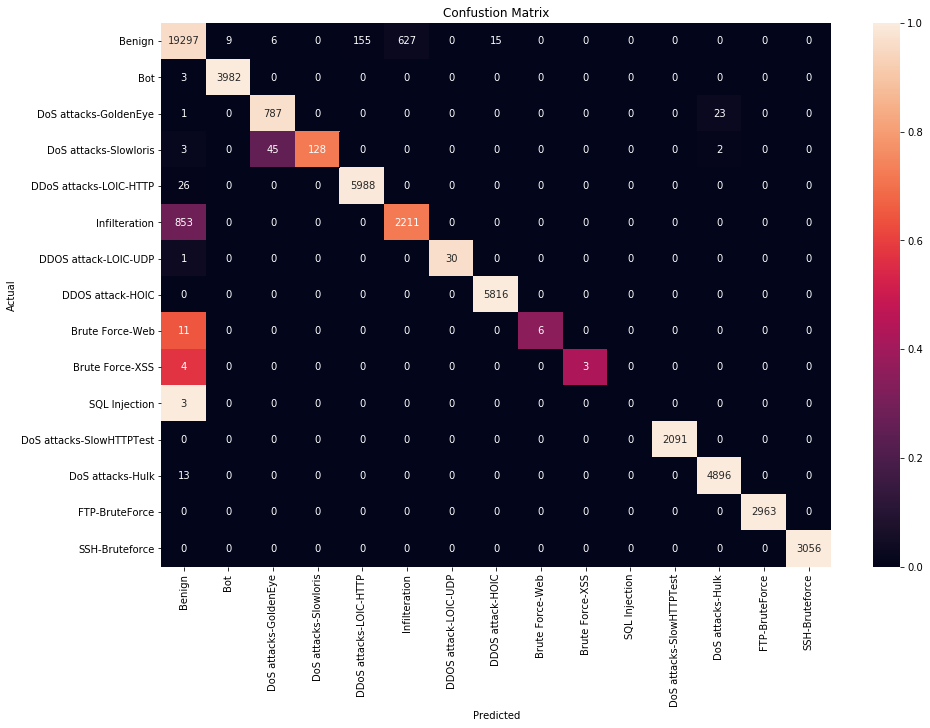

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output

class_list = ['Benign','Bot','DoS attacks-GoldenEye','DoS attacks-Slowloris','DDoS attacks-LOIC-HTTP','Infilteration','DDOS attack-LOIC-UDP','DDOS attack-HOIC','Brute Force-Web','Brute Force-XSS','SQL Injection','DoS attacks-SlowHTTPTest','DoS attacks-Hulk','FTP-BruteForce','SSH-Bruteforce']
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(actual,predictions)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confustion Matrix')
plt.show()

Finally, let's gracefully stop the deployed endpoint.

In [ ]:
predictor.delete_endpoint()

## References

A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018) https://registry.opendata.aws/cse-cic-ids2018/